### 1D Autoregressive Token prediction

In [213]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
import random
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax import random
import contextlib

#### Data Preparation

##### Geometric Brownian Motion Simulator

$dS_t = \mu S_tdt + \sigma S_tdW_t \\$

$S_0$: Initial Stock price $\\$
$\mu$: Drift coefficient $\\$
$\sigma$: Volatility coefficient $\\$
$W_t$: Wiener Process (Brownian motion)

In [101]:
def gbm_simulator(key, S0, mu, sigma, T, dt):
    # Number of time steps
    N = int(T / dt)
    t = jnp.linspace(0, T, N)
    W = random.normal(key, (N,)) * jnp.sqrt(dt)
    
    # Wiener process
    W = jnp.cumsum(W)
    S = S0 * jnp.exp((mu - 0.5 * sigma**2) * t + sigma * W)
    return S

# Parameters for the GBM
S0 = 100.0                  # Initial stock price
mu = 0.1                    # Drift coefficient
sigma = 0.2                 # Volatility coefficient
T = 5.0                     # Total time (year)
dt = 0.005                  # Time step

# Generate random key
key = random.PRNGKey(0)

# Simulate GBM
GBM_data = gbm_simulator(key, S0, mu, sigma, T, dt)

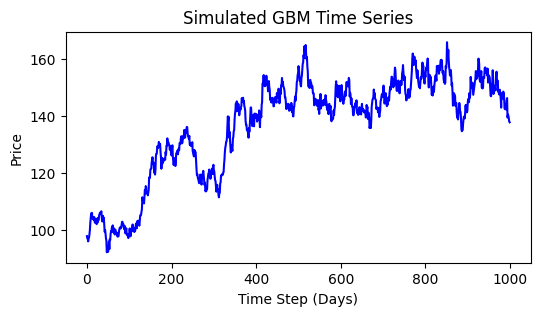

Mean Price: 136.36
Standard Deviation of Price: 17.87


In [102]:
# Plot the time series
plt.figure(figsize=(6, 3))
plt.plot(GBM_data, color ='blue')
plt.title('Simulated GBM Time Series')
plt.xlabel('Time Step (Days)')
plt.ylabel('Price')
plt.show()

# Calculate and print basic statistics
mean_price = jnp.mean(GBM_data)
std_dev_price = jnp.std(GBM_data)
print(f"Mean Price: {mean_price:.2f}")
print(f"Standard Deviation of Price: {std_dev_price:.2f}")

Discretizng data

In [103]:
data = np.array(GBM_data)
bin_start = 30
bin_stop = 180
num_bins = 30
bin_edges = np.linspace(bin_start, bin_stop, num_bins + 1)
# Tokenize the data
tokenized_data = np.digitize(GBM_data, bins=bin_edges, right=False) - 1
# Clip any prices below 30 to the first bin and above 170 to the last bin (Token 0 to 29)
tokenized_data = np.clip(tokenized_data, 0, num_bins - 1)
# Train / Test Split
train_data_temp, temp_data = train_test_split(tokenized_data, train_size=0.7, shuffle=False)
val_data_temp, test_data_temp = train_test_split(temp_data, test_size=0.5, shuffle=False)

def prep_data(seq_len, start_indexes, data):
    final_list = []
    for i in start_indexes:
        final_list.append(data[i:i+seq_len])
    return final_list

In [104]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        # Embedding Layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # LSTM Layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        # Fully Connected Layer
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x, hidden=None):
        # A sequence of 50 tokens is passed to the embedding layer and we get the embeddings for each token (dimension: 32)
        embedded = self.embedding(x)                            # Shape: [batch_size, sequence_length, embedding_dim] [1, 50, 32]
        # LSTM layer
        lstm_out, (h_n, c_n) = self.lstm(embedded, hidden)      # Input: 50 tokens, Output: 50 hidden states with dimension 128
        # Apply fully connected layer to each time step
        logits = self.fc(lstm_out)                              # Shape: [batch_size, sequence_length, output_dim]
        
        return logits, hidden                                   # Return predictions for each time step

In [105]:
seq_len = 50
train_n_seq = 10

val_data = []
for i in range(len(val_data_temp) // seq_len):
    start_idx = i * seq_len
    end_idx = start_idx + seq_len
    val_data.append(val_data_temp[start_idx:end_idx])

Loss function and training

In [106]:
model = LSTMModel(vocab_size=num_bins, embedding_dim=32, hidden_dim=64, output_dim=num_bins)

# Loss function
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training

num_epochs = 300
train_losses = []
validation_losses = []

for epoch in range(num_epochs):
    
    start_train_idx = np.random.choice(range(len(train_data_temp)-seq_len), size=train_n_seq, replace=True)
    train_data = prep_data(seq_len=seq_len, start_indexes=start_train_idx, data=train_data_temp)
    
    ## TRAINING
    model.train()
    train_loss = 0
    for sequence in train_data:
        
        optimizer.zero_grad()

        sequence_input = torch.tensor(sequence[:-1]).unsqueeze(0)   # Exclude last token
        targets = torch.tensor(sequence[1:]).unsqueeze(0)           # Exclude first token

        # Shape: [1, sequence_length-1, unique_tokens]
        logits, _ = model(sequence_input)                              # [Token 1, Token 2, ..., Token 49]
        # Reshape logits to combine batch and sequence dimensions
        logits = logits.view(-1, logits.size(-1))                   # Shape: [1*49, 30] -> [49, 30]
        targets = targets.view(-1)                                  # Flatten targets to shape [49]
        # Average loss across all 49 tokens
        loss = criterion(logits, targets)
        train_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
    
    avg_train_loss = train_loss/len(train_data)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch} - Avg Loss per sequence: {avg_train_loss:.4f}")

    ## VALIDATION
    model.eval()
    validation_loss = 0

    # No weight updates
    with torch.no_grad():
        for sequence in val_data:
            sequence_input = torch.tensor(sequence[:-1]).unsqueeze(0)   # Exclude last token
            targets = torch.tensor(sequence[1:]).unsqueeze(0)           # Exclude first token

            logits, _ = model(sequence_input)  # Forward pass
            logits = logits.view(-1, logits.size(-1))  # Shape: [49, 30]
            targets = targets.view(-1)  # Shape: [49]                        
            loss = criterion(logits, targets)
            validation_loss += loss.item()
        
    avg_val_loss = validation_loss / len(val_data)
    validation_losses.append(avg_val_loss)
    print(f"Epoch {epoch}, Validation Loss: {avg_val_loss:.4f}")

# Save model weights after training/validation
torch.save(model.state_dict(), 'model_weights.pth')

Epoch 0 - Avg Loss per sequence: 3.1876
Epoch 0, Validation Loss: 3.1322
Epoch 1 - Avg Loss per sequence: 3.2240
Epoch 1, Validation Loss: 3.0068
Epoch 2 - Avg Loss per sequence: 2.7802
Epoch 2, Validation Loss: 2.7748
Epoch 3 - Avg Loss per sequence: 2.7213
Epoch 3, Validation Loss: 2.4760
Epoch 4 - Avg Loss per sequence: 2.1296
Epoch 4, Validation Loss: 2.1697
Epoch 5 - Avg Loss per sequence: 1.8491
Epoch 5, Validation Loss: 1.9151
Epoch 6 - Avg Loss per sequence: 1.9107
Epoch 6, Validation Loss: 1.8343
Epoch 7 - Avg Loss per sequence: 1.6228
Epoch 7, Validation Loss: 1.8768
Epoch 8 - Avg Loss per sequence: 1.5154
Epoch 8, Validation Loss: 1.8168
Epoch 9 - Avg Loss per sequence: 1.4527
Epoch 9, Validation Loss: 1.7445
Epoch 10 - Avg Loss per sequence: 1.2788
Epoch 10, Validation Loss: 1.7429
Epoch 11 - Avg Loss per sequence: 1.2229
Epoch 11, Validation Loss: 1.7685
Epoch 12 - Avg Loss per sequence: 1.1671
Epoch 12, Validation Loss: 1.7246
Epoch 13 - Avg Loss per sequence: 1.2514
Epoc

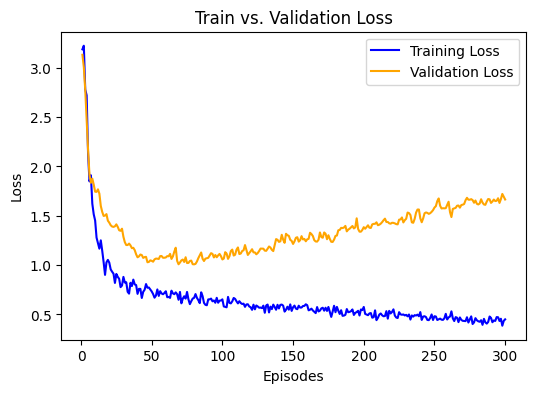

In [107]:
plt.figure(figsize=(6,4))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss', color='blue')
plt.plot(range(1, len(validation_losses)+1), validation_losses, label = 'Validation Loss', color='orange')
plt.title('Train vs. Validation Loss')
plt.xlabel('Episodes')
plt.ylabel('Loss')
plt.legend()
plt.show()

TESTING

In [108]:
model = LSTMModel(vocab_size=num_bins, embedding_dim=32, hidden_dim=64, output_dim=num_bins)
model.load_state_dict(torch.load('model_weights.pth'))

/var/folders/1x/hjv8bl714_xgsbdy8fp5kj140000gn/T/ipykernel_47285/4196944748.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_weigh

<All keys matched successfully>

In [120]:
start_test_idx = np.random.choice(range(len(test_data_temp)-seq_len), size=100, replace=True)
test_data = prep_data(seq_len=seq_len, start_indexes=start_test_idx, data=test_data_temp)

## TESTING
test_losses = []
trajectories = []

for sequence in test_data:
    init_real_token = sequence[0]
    sim_trajectory = [init_real_token]
    model.eval()
    # Initialize hidden and cell states to zero
    ## PLEASE ADJUST WHEN HAVING MULTIPLE LSTM LAYERS
    h_n = torch.zeros(1, 1, 64)
    c_n = torch.zeros(1, 1, 64)
    ##
    with torch.no_grad():
        token_loss = 0
        for i in range(1, len(sequence)):
            # Last value in the trajectory
            sequence_input = torch.tensor([sim_trajectory[-1]]).unsqueeze(0)
            
            # Get the model's prediction and pass the hidden and cell states
            logits, (h_n, c_n) = model(sequence_input, (h_n, c_n))
            
            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)
            probs = probs.squeeze()
            predicted_token = torch.multinomial(probs, num_samples=1).item()
            sim_trajectory.append(predicted_token)
            
            # Loss calculation
            true_token = torch.tensor([sequence[i]]).unsqueeze(0)
            true_token = true_token.view(-1)  
            logits = logits.view(-1, logits.size(-1))                                             
            loss = criterion(logits, true_token)
            token_loss += loss.item()
            
    test_losses.append(token_loss/len(sequence))
    trajectories.append(sim_trajectory)

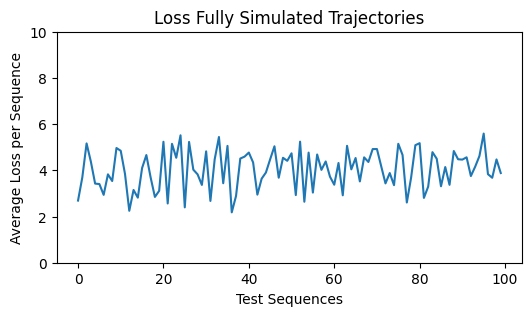

In [121]:
plt.figure(figsize=(6,3))
plt.plot(test_losses)
plt.title("Loss Fully Simulated Trajectories")
plt.xlabel('Test Sequences')
plt.ylabel('Average Loss per Sequence')
plt.ylim(0, 10)
plt.show()

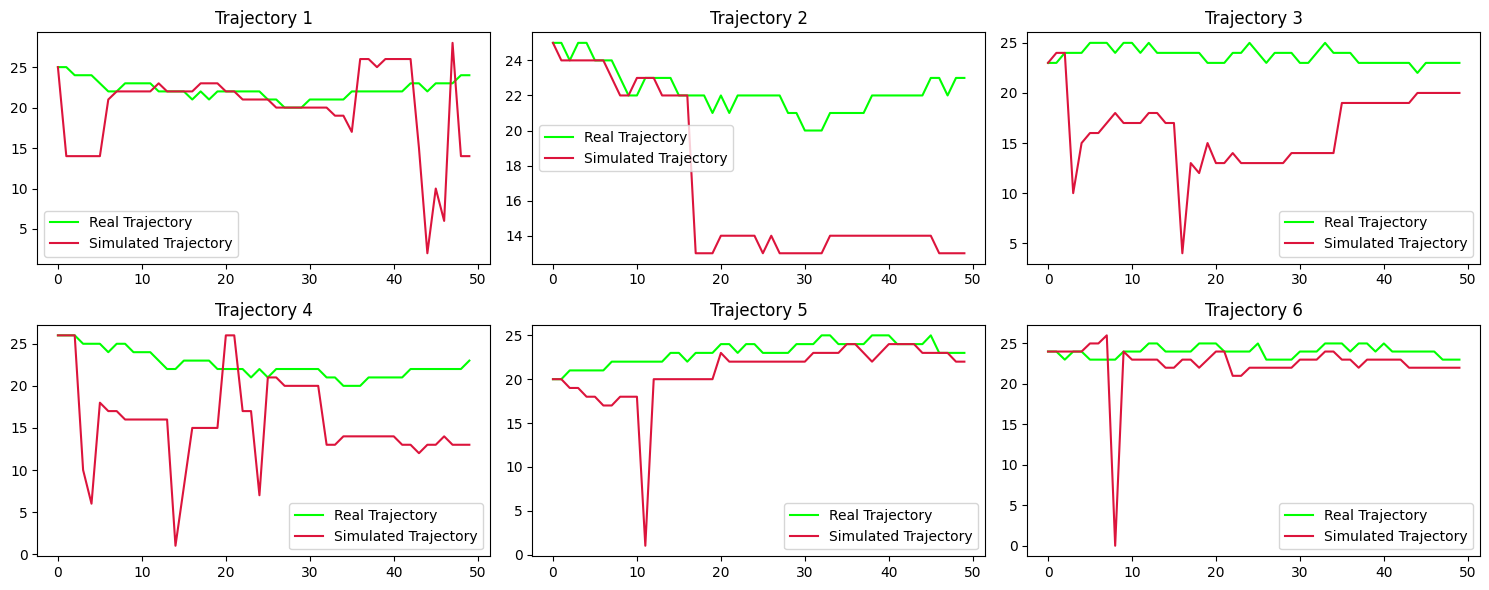

In [122]:
fig, axes = plt.subplots(2, 3, figsize=(15, 6))  # 2 rows, 5 columns, and adjust the size
axes = axes.flatten()
for i in range(6):
    axes[i].plot(test_data[i], label='Real Trajectory', color = 'lime')
    axes[i].plot(trajectories[i], label='Simulated Trajectory', color = 'crimson')
    axes[i].legend()
    axes[i].set_title(f'Trajectory {i+1}')
plt.tight_layout()
plt.show()

Testing with ARGMAX instead of Sampling

In [118]:
## TESTING
test_losses = []
trajectories = []

for sequence in test_data:
    init_real_token = sequence[0]
    sim_trajectory = [init_real_token]
    model.eval()
    # Initialize hidden and cell states to zero
    ## PLEASE ADJUST WHEN HAVING MULTIPLE LSTM LAYERS
    h_n = torch.zeros(1, 1, 64)
    c_n = torch.zeros(1, 1, 64)
    ##
    with torch.no_grad():
        token_loss = 0
        for i in range(1, len(sequence)):
            # Last value in the trajectory
            sequence_input = torch.tensor([sim_trajectory[-1]]).unsqueeze(0)
            
            # Get the model's prediction and pass the hidden and cell states
            logits, (h_n, c_n) = model(sequence_input, (h_n, c_n))
            
            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)
            probs = probs.squeeze()
            predicted_token = torch.argmax(probs).item()
            sim_trajectory.append(predicted_token)
            
            # Loss calculation
            true_token = torch.tensor([sequence[i]]).unsqueeze(0)
            true_token = true_token.view(-1)  
            logits = logits.view(-1, logits.size(-1))                                             
            loss = criterion(logits, true_token)
            token_loss += loss.item()
            
    test_losses.append(token_loss/len(sequence))
    trajectories.append(sim_trajectory)

#### WHEN ARGMAX IS USED

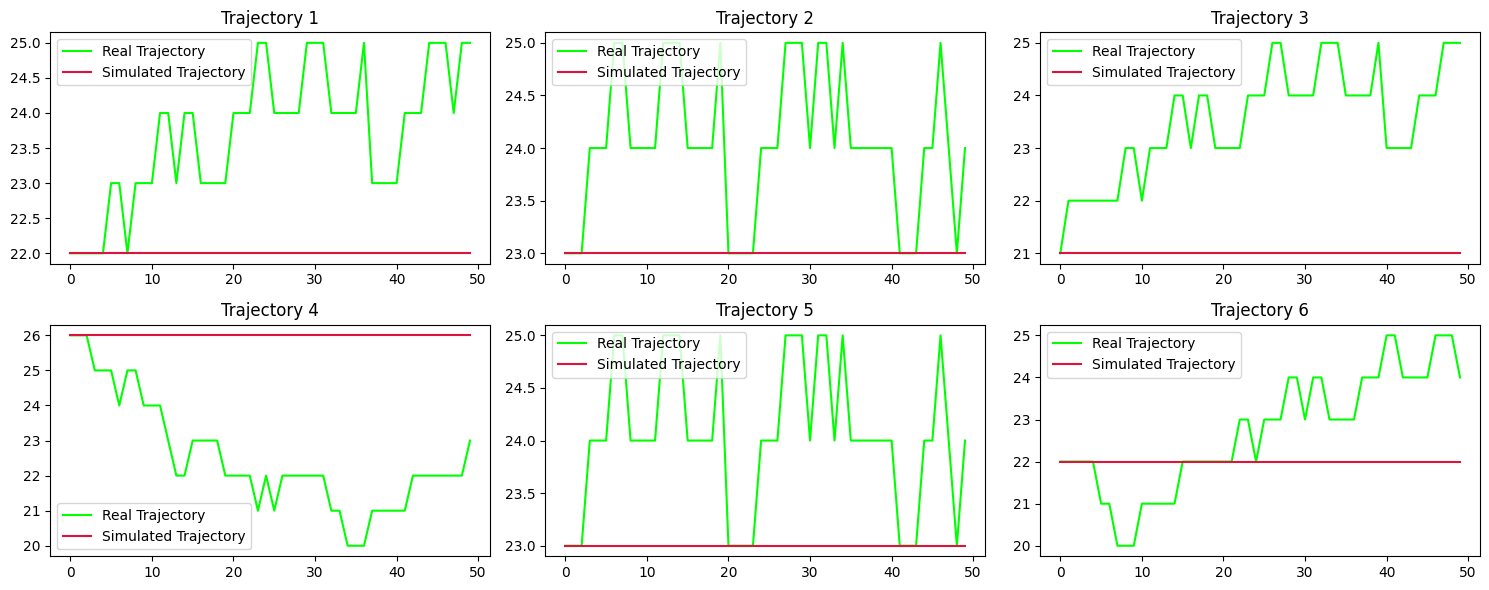

In [119]:
fig, axes = plt.subplots(2, 3, figsize=(15, 6))  # 2 rows, 5 columns, and adjust the size
axes = axes.flatten()
for i in range(6):
    axes[i].plot(test_data[i], label='Real Trajectory', color = 'lime')
    axes[i].plot(trajectories[i], label='Simulated Trajectory', color = 'crimson')
    axes[i].legend()
    axes[i].set_title(f'Trajectory {i+1}')
plt.tight_layout()
plt.show()

### GAN Framework

Generator & Discriminator Setup

In [224]:
## Change architecture when moving to refining your model
##

# Same as in self-supervised setting
class LSTMGenerator(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(LSTMGenerator, self).__init__()
        # Embedding Layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # LSTM Layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        # Fully Connected Layer
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x, hidden=None):
        embedded = self.embedding(x)
        lstm_out, (h_n, c_n) = self.lstm(embedded, hidden)
        logits = self.fc(lstm_out)
        return logits, hidden

## Simple Discriminator LSTM Network with binary classification
class LSTMDiscriminator(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):              # Output size is one
        super(LSTMDiscriminator, self).__init__()
        # Embedding Layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # LSTM Layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        # Fully Connected Layer
        self.fc = nn.Linear(hidden_dim, 1)  # Output single probability
        # Sigmoid Activation for binary classification
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, hidden=None):
        embedded = self.embedding(x)
        lstm_out, hidden = self.lstm(embedded, hidden)
        logits = self.fc(lstm_out)
        prob = self.sigmoid(logits)
        prob = prob.squeeze(-1) 
        return prob, hidden

$\beta_1:$  Controls the decay rate for the moving average of past gradients. The default value is usually 0.9, but in GANs, it's often set to 0.5. Setting $\beta_1$ to 0.5 can help stabilize GAN training, as it reduces the momentum effect, preventing the optimizer from overshooting or oscillating too much.


$\beta_2:$ Controls the decay rate for the moving average of the squared gradients. It affects how the optimizer adjusts the learning rate based on the variance of the past gradients.

In [225]:
def create_fake_sequences(generator, real_sequence, training=False):
    
    ## CREATE FAKE SEQUENCE
    init_real_token = real_sequence[0]
    fake_sequence = [init_real_token]

    ## PLEASE ADJUST WHEN HAVING MULTIPLE LSTM LAYERS
    h_n = torch.zeros(1, 1, 64)
    c_n = torch.zeros(1, 1, 64)
    ##
    
    generator.train() if training else generator.eval()
    
    # If testing, then no gradient calculations
    with torch.no_grad() if not training else contextlib.nullcontext():
        for _ in range(1, len(real_sequence)):
            sequence_input = torch.tensor([fake_sequence[-1]]).unsqueeze(0)
            logits, (h_n, c_n) = generator(sequence_input, (h_n, c_n))
            probs = torch.softmax(logits, dim=-1).squeeze()
            predicted_token = torch.multinomial(probs, num_samples=1).item()
            fake_sequence.append(predicted_token)
    fake_sequence = torch.tensor(fake_sequence[1:]).unsqueeze(0)
    
    return fake_sequence


In [269]:
# Instantiate and load the weights
generator = LSTMGenerator(vocab_size=num_bins, embedding_dim=32, hidden_dim=64, output_dim=num_bins)
generator.load_state_dict(torch.load('model_weights.pth'))

# Instantiate
discriminator = LSTMDiscriminator(vocab_size=num_bins, embedding_dim=32, hidden_dim=64)

# Loss function
criterion = nn.BCELoss()
# Optimizers
D_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
G_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))


/var/folders/1x/hjv8bl714_xgsbdy8fp5kj140000gn/T/ipykernel_47285/2229166961.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load('model_w

GAN TRAINING

In [270]:
G_losses = []
D_losses = []

real_sequences = []
fake_seq_dis_train = []
fake_seq_gen_train = []
final_prob_dis_train = []
final_prob_gen_train = []

for sequence in test_data:
    
    real_sequence = torch.tensor(sequence[1:]).unsqueeze(0)
    real_sequences.append(real_sequence.squeeze())
    
    ## ===================
    ## TRAIN DISCRIMINATOR
    ## ===================
    
    # Generate fake sequences but in test mode!
    fake_sequence = create_fake_sequences(generator, sequence, training=False)
    fake_seq_dis_train.append(fake_sequence.squeeze())

    # Zero the gradients
    D_optimizer.zero_grad()
    
    # 1. Train on real sequence (compare to 1, since 1 = real sequence)
    D_real, _ = discriminator(real_sequence)
    final_prob = D_real[:, -1]
    D_loss_real = criterion(final_prob, torch.ones_like(final_prob))
    
    # 2. Train on fake sequence (compare to 0, since 0 = fake sequence)
    D_fake, _ = discriminator(fake_sequence)
    # Probabilty after the whole sequence
    final_prob = D_fake[:, -1]
    final_prob_dis_train.append(final_prob)
    D_loss_fake = criterion(final_prob, torch.zeros_like(final_prob))
    
    # Discriminator's Loss and Optimization
    D_loss = (D_loss_real + D_loss_fake) / 2
    D_loss.backward()
    D_optimizer.step()

    ## ===============
    ## TRAIN GENERATOR
    ## ===============

    # Zero the gradients
    G_optimizer.zero_grad()

    # Generate fake sequences but in train mode!
    fake_sequence = create_fake_sequences(generator, sequence, training=True)
    fake_seq_gen_train.append(fake_sequence.squeeze())

    D_fake, _ = discriminator(fake_sequence)
    # Probabilty after the whole sequence
    final_prob = D_fake[:, -1]
    final_prob_gen_train.append(final_prob)

    # Generator's Loss and Optimization
    G_loss = criterion(final_prob, torch.ones_like(final_prob))
    G_loss.backward()
    G_optimizer.step()

    # Print progress at the end of each epoch
    print(f'Epoch [{epoch+1}/{num_epochs}] | D Loss: {D_loss.item():.4f} | G Loss: {G_loss.item():.4f}')


Epoch [300/300] | D Loss: 0.6557 | G Loss: 0.7387
Epoch [300/300] | D Loss: 0.6900 | G Loss: 0.6629
Epoch [300/300] | D Loss: 0.6449 | G Loss: 0.7527
Epoch [300/300] | D Loss: 0.6404 | G Loss: 0.6515
Epoch [300/300] | D Loss: 0.6248 | G Loss: 0.6570
Epoch [300/300] | D Loss: 0.6932 | G Loss: 0.6693
Epoch [300/300] | D Loss: 0.7547 | G Loss: 0.6172
Epoch [300/300] | D Loss: 0.7017 | G Loss: 0.7169
Epoch [300/300] | D Loss: 0.7005 | G Loss: 0.6773
Epoch [300/300] | D Loss: 0.6930 | G Loss: 0.6614
Epoch [300/300] | D Loss: 0.7435 | G Loss: 0.6138
Epoch [300/300] | D Loss: 0.6375 | G Loss: 0.6935
Epoch [300/300] | D Loss: 0.6147 | G Loss: 0.6526
Epoch [300/300] | D Loss: 0.7068 | G Loss: 0.7111
Epoch [300/300] | D Loss: 0.6481 | G Loss: 0.7842
Epoch [300/300] | D Loss: 0.7093 | G Loss: 0.6012
Epoch [300/300] | D Loss: 0.6893 | G Loss: 0.6743
Epoch [300/300] | D Loss: 0.6607 | G Loss: 0.7556
Epoch [300/300] | D Loss: 0.6902 | G Loss: 0.6899
Epoch [300/300] | D Loss: 0.7466 | G Loss: 0.7349


In [271]:
print(G_loss)
print(D_loss)
print(real_sequences)
print(fake_seq_dis_train)
print(fake_seq_gen_train)
print(final_prob_dis_train)
print(final_prob_gen_train)

tensor(0.8889, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4760, grad_fn=<DivBackward0>)
[tensor([25, 24, 24, 24, 23, 22, 22, 23, 23, 23, 23, 22, 22, 22, 22, 21, 22, 21,
        22, 22, 22, 22, 22, 22, 21, 21, 20, 20, 20, 21, 21, 21, 21, 21, 22, 22,
        22, 22, 22, 22, 22, 23, 23, 22, 23, 23, 23, 24, 24]), tensor([25, 24, 25, 25, 24, 24, 24, 23, 22, 22, 23, 23, 23, 23, 22, 22, 22, 22,
        21, 22, 21, 22, 22, 22, 22, 22, 22, 21, 21, 20, 20, 20, 21, 21, 21, 21,
        21, 22, 22, 22, 22, 22, 22, 22, 23, 23, 22, 23, 23]), tensor([23, 24, 24, 24, 25, 25, 25, 24, 25, 25, 24, 25, 24, 24, 24, 24, 24, 24,
        23, 23, 23, 24, 24, 25, 24, 23, 24, 24, 24, 23, 23, 24, 25, 24, 24, 24,
        23, 23, 23, 23, 23, 23, 23, 22, 23, 23, 23, 23, 23]), tensor([26, 26, 25, 25, 25, 24, 25, 25, 24, 24, 24, 23, 22, 22, 23, 23, 23, 23,
        22, 22, 22, 22, 21, 22, 21, 22, 22, 22, 22, 22, 22, 21, 21, 20, 20, 20,
        21, 21, 21, 21, 21, 22, 22, 22, 22, 22, 22, 22, 23]), tensor([20, 21, 21

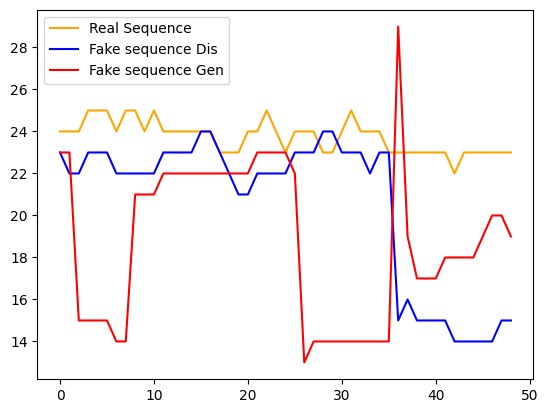

In [272]:
plt.plot(real_sequences[-1], color = 'orange', label = 'Real Sequence')
plt.plot(fake_seq_dis_train[-1], color = 'blue', label = 'Fake sequence Dis')
plt.plot(fake_seq_gen_train[-1], color = 'red', label = 'Fake sequence Gen')
plt.legend()
plt.show()
#plt.plot(fake_seq_gen_train[-1])